<a href="https://colab.research.google.com/github/tejpal123456789/Machine-Translation/blob/main/english_french.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 15000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []

with open('/content/drive/MyDrive/fra.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(NUM_SENTENCES, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "start " + target_text + " end"
    input_texts.append(input_text)
    target_texts.append(target_text)
    

In [4]:
df = pd.DataFrame(list(zip(input_texts, target_texts)),
               columns =['english', 'french'])

In [5]:
df.head()

,english,french
0,Go.,start Va ! end
1,Go.,start Marche. end
2,Go.,start Bouge ! end
3,Hi.,start Salut ! end
4,Hi.,start Salut. end


In [6]:

print("num samples input:", len(input_texts))
print("num samples output:", len(target_texts))


num samples input: 15000
num samples output: 15000


In [7]:
input_sentences=input_texts
output_sentences=target_texts

In [8]:
print(input_sentences[172])
print(output_sentences[172])


Beat it.
start Bouge ! end


In [9]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 2813
Length of longest sentence in input: 5


In [10]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences )
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
#output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 7723
Length of longest sentence in the output: 13


In [11]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (15000, 5)
encoder_input_sequences[172]: [  0   0   0 237   3]


In [12]:
decoder_input_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (15000, 13)
decoder_input_sequences[172]: [  1 315   4   2   0   0   0   0   0   0   0   0   0]


In [13]:
print(word2idx_inputs["i'm"])
print(word2idx_inputs["ill"])

5
440


In [14]:
print(word2idx_outputs["start"])
print(word2idx_outputs["je"])
print(word2idx_outputs["suis"])
print(word2idx_outputs["malade."])

1
3
6
170


In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/drive/MyDrive/Glove/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()                            

In [16]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [18]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [19]:
decoder_targets_one_hot.shape

(15000, 13, 7724)

In [20]:
for i, d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t-1, word] = 1

In [21]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [22]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [23]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [24]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

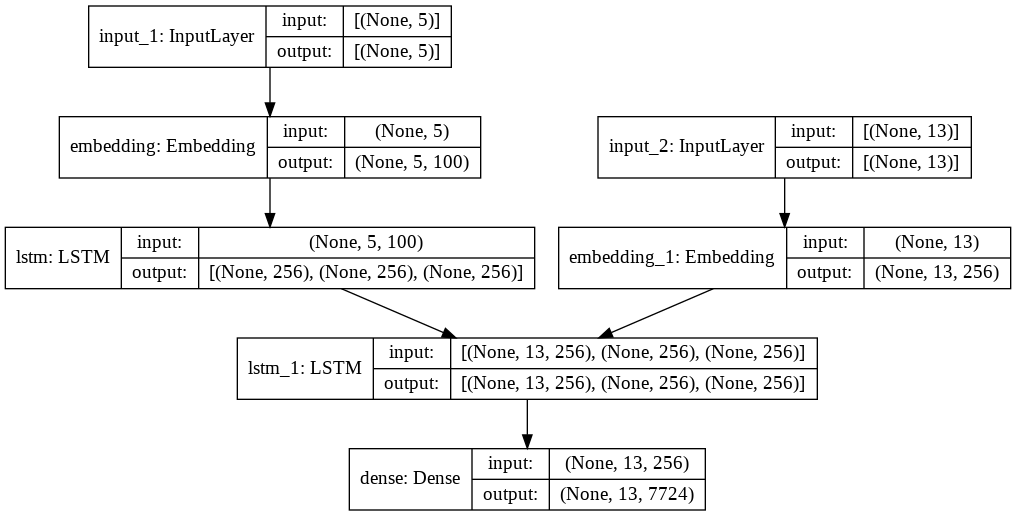

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [26]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20
211/211 [==============================] - 44s 47ms/step - loss: 2.8520 - accuracy: 0.6116 - val_loss: 2.0452 - val_accuracy: 0.7152
Epoch 2/20
211/211 [==============================] - 9s 42ms/step - loss: 1.5920 - accuracy: 0.7229 - val_loss: 1.7899 - val_accuracy: 0.7478
Epoch 3/20
211/211 [==============================] - 9s 42ms/step - loss: 1.3542 - accuracy: 0.7894 - val_loss: 2.0069 - val_accuracy: 0.6865
Epoch 4/20
211/211 [==============================] - 9s 41ms/step - loss: 1.2154 - accuracy: 0.8133 - val_loss: 1.8109 - val_accuracy: 0.7056
Epoch 5/20
211/211 [==============================] - 9s 42ms/step - loss: 1.1230 - accuracy: 0.8249 - val_loss: 1.5144 - val_accuracy: 0.7843
Epoch 6/20
211/211 [==============================] - 9s 41ms/step - loss: 1.0361 - accuracy: 0.8378 - val_loss: 1.4563 - val_accuracy: 0.7914
Epoch 7/20
211/211 [==============================] - 9s 42ms/step - loss: 0.9712 - accuracy: 0.8450 - val_loss: 1.4381 - val_accuracy: 0.794

In [27]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [28]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [29]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [30]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [31]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)


In [32]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

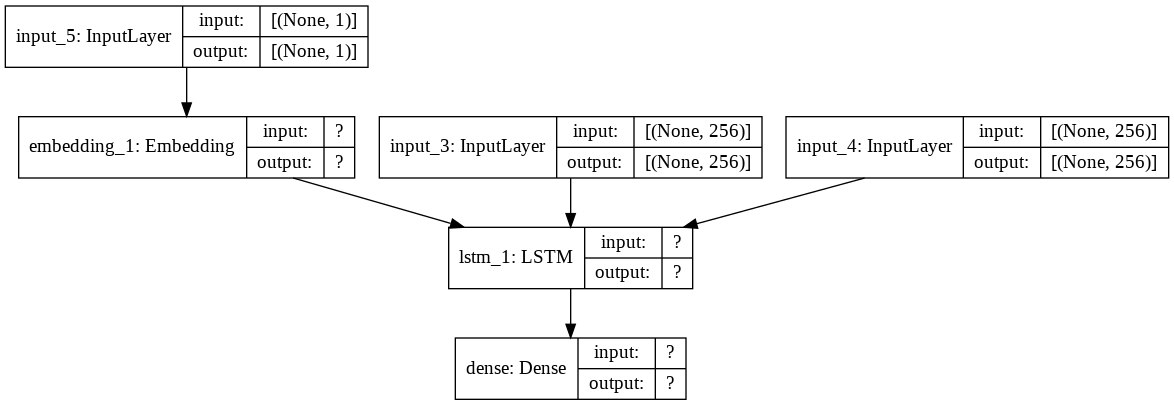

In [33]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [34]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [35]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['start']
    eos = word2idx_outputs['end']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [40]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('original',output_sentences[i])
print('Response:', translation)

-
Input: He is young.
original start Il est jeune. end
Response: il est jeune.
